<a href="https://colab.research.google.com/github/smaranjitghose/DeepHoli/blob/master/Deep_Holi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starting off by importing the necessary dependencies

In [0]:
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import tensorflow as tf
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from scipy.optimize import fmin_l_bfgs_b

# Defining our parameters

In [0]:
ITERATIONS = 30
CHANNELS = 3
IMAGE_SIZE = 500
IMAGE_WIDTH = IMAGE_SIZE
IMAGE_HEIGHT = IMAGE_SIZE
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]
CONTENT_WEIGHT = 0.02
STYLE_WEIGHT = 4.5
TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25

# First lets have our content image 

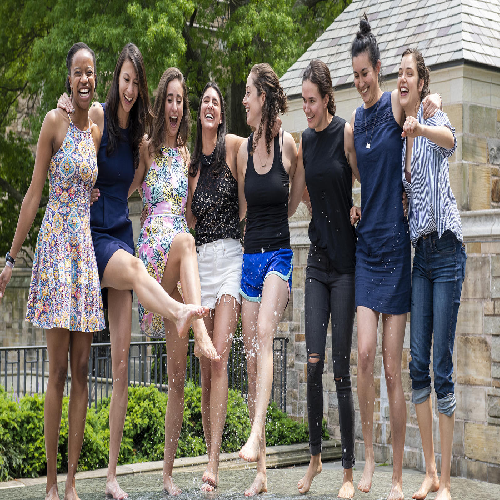

In [31]:
content_image = Image.open(BytesIO(requests.get("https://alumni.yale.edu/sites/default/files/styles/16_9_1600x900/public/2019-06/2%20-%202019_06_01%20Yale%20Reunions%20Saturday%20II%20social%203295_Lavitt.jpg?h=3f40b069&itok=4kr8q4dj").content))
content_image = content_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT)) #Resizing it
content_image.save("content.png") #Saving it 
content_image

## Now, the style image for Holi

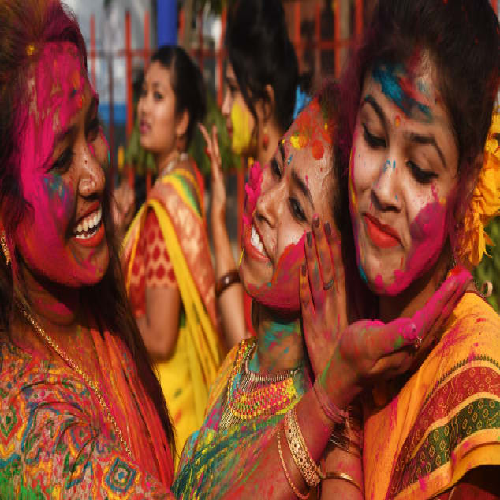

In [32]:
style_image = Image.open(BytesIO(requests.get("https://dynaimage.cdn.cnn.com/cnn/q_auto,w_634,c_fill,g_auto,h_357,ar_16:9/http%3A%2F%2Fcdn.cnn.com%2Fcnnnext%2Fdam%2Fassets%2F180302095559-holi-2018-4.jpg").content))
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image.save("style.png")
style_image

# Normalizing the data and reshaping from RGB to BGR

In [0]:
content_image_array = np.asarray(content_image, dtype="float32")
content_image_array = np.expand_dims(content_image_array, axis=0)
content_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
content_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
content_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
content_image_array = content_image_array[:, :, :, ::-1]

style_image_array = np.asarray(style_image, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)
style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
style_image_array = style_image_array[:, :, :, ::-1]

# Getting our model for transfer learning

In [0]:
content_image = backend.variable(content_image_array)
style_image = backend.variable(style_image_array)
combination_image = backend.placeholder((1,IMAGE_HEIGHT,IMAGE_WIDTH, 3))

input_tensor = backend.concatenate([content_image,style_image,combination_image], axis=0)
model = VGG16(input_tensor=input_tensor, include_top=False)

# Content Loss Function

In [35]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layers = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = "block2_conv2"
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = backend.variable(0.)
loss += CONTENT_WEIGHT * content_loss(content_image_features,
                                      combination_features)

# Gram Matrix

In [0]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

# Style Loss Function

In [0]:
def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))



## Calculating Style Loss for all the layers


In [0]:
style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (STYLE_WEIGHT / len(style_layers)) * style_loss

## Total Variation Loss

In [0]:
def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)

In [0]:
outputs = [loss]
outputs += backend.gradients(loss, combination_image)


In [0]:
def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

# Executing our model

Iteration 0 completed with loss 123738472448
Iteration 1 completed with loss 51041230848
Iteration 2 completed with loss 26564374528
Iteration 3 completed with loss 19510810624
Iteration 4 completed with loss 16918671360
Iteration 5 completed with loss 15802324992
Iteration 6 completed with loss 15333439488
Iteration 7 completed with loss 15008828416
Iteration 8 completed with loss 14794817536
Iteration 9 completed with loss 14649528320
Iteration 10 completed with loss 14549245952
Iteration 11 completed with loss 14475188224
Iteration 12 completed with loss 14417521664
Iteration 13 completed with loss 14375404544
Iteration 14 completed with loss 14338335744
Iteration 15 completed with loss 14310882304
Iteration 16 completed with loss 14290310144
Iteration 17 completed with loss 14273470464
Iteration 18 completed with loss 14259230720
Iteration 19 completed with loss 14247355392
Iteration 20 completed with loss 14237847552
Iteration 21 completed with loss 14229420032
Iteration 22 comple

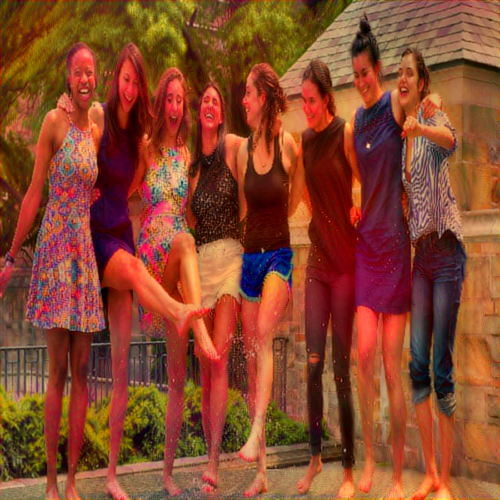

In [46]:
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

for i in range(ITERATIONS):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
x = x[:, :, ::-1]
x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save('output.png')
output_image

# Lets have a amalgated image of the content image,style image and the stylized image

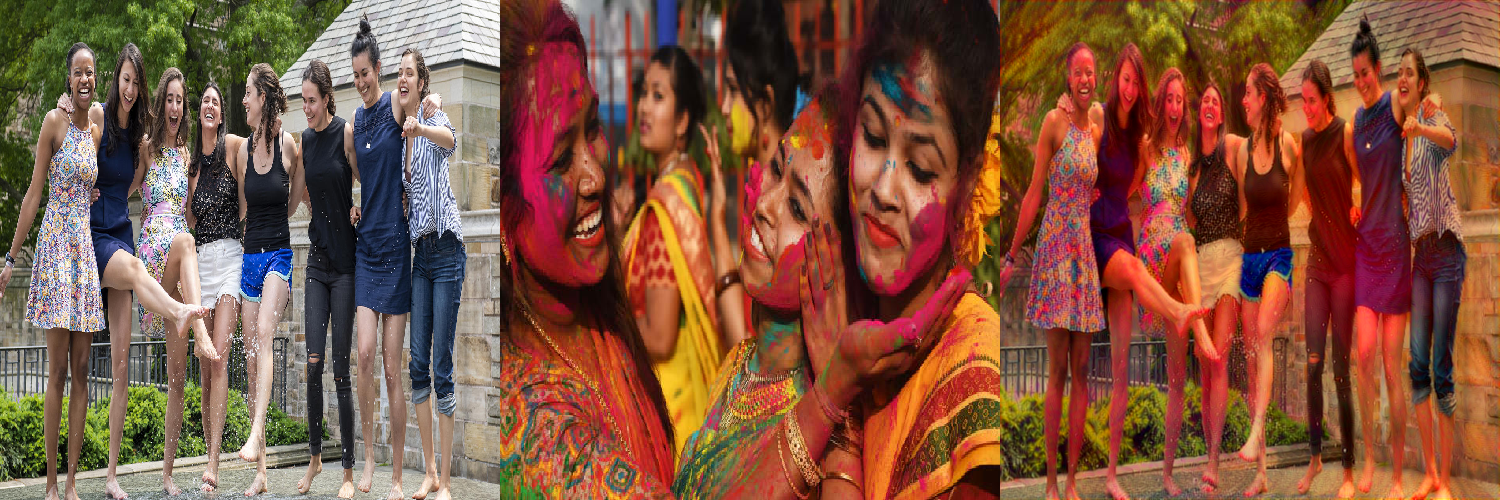

In [49]:
amalgated_image = Image.new("RGB", (IMAGE_WIDTH*3, IMAGE_HEIGHT))
x_offset = 0
for image in map(Image.open, ["content.png", "style.png", "output.png"]):
    amalgated_image.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
amalgated_image.save("amalgated.png")
amalgated_image